In [ ]:
!kaggle datasets download -d ming666/flicker8k-dataset

100% 2.07G/2.08G [00:22<00:00, 27.6MB/s]
100% 2.08G/2.08G [00:22<00:00, 98.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:

!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:08<00:00, 125MB/s]
100% 1.04G/1.04G [00:08<00:00, 137MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
token_path = "/content/gdrive/My Drive/Kaggle/flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/gdrive/My Drive/Kaggle/flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/gdrive/My Drive/Kaggle/flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/gdrive/My Drive/Kaggle/Images/'

doc = open(token_path,'r').read()
print(doc[:410])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)
print(descriptions)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)
print(desc)
print(desc_list[i] )

['a', 'rock', 'climber', 'practices', 'on', 'a', 'rock', 'climbing', 'wall', '']
a rock climber practices on a rock climbing wall 


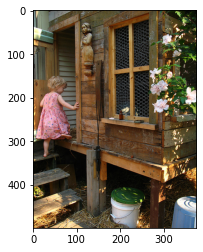

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)
#print(new_descriptions)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)
print(train)




{'3687995245_624b54090d', '2156726763_034ecd2e39', '365759754_6cf7068c9a', '3247168324_c45eaf734d', '3122888809_9ae9b4b9b2', '765298136_7805fbb079', '2281054343_95d6d3b882', '197142902_f05ff198c2', '2599131872_65789d86d5', '3568605391_54ec367d88', '3756150099_50882fc029', '3577235421_69e4efb8d1', '2870194345_0bcbac1aa5', '2469351714_d72becd21e', '2661294481_b86058b504', '241346885_f519ece460', '2623982903_58ec7c5026', '2924483864_cfdb900a13', '3601533527_6c2439113c', '3359587274_4a2b140b84', '237277765_9e6fa5b99a', '242324909_06d5a6c44b', '1429723917_6af585e4c0', '1093737381_b313cd49ff', '2715337869_e4fe36db50', '3288274849_07ff76ee93', '3215238223_29de2b35cb', '3259229498_2b5708c0c6', '2068960566_21e85ae0dc', '1305564994_00513f9a5b', '3634400263_c6fcaa48e1', '3220009216_10f088185e', '2580215443_4e64afe3d5', '3205336477_037d4b6bd9', '3562169000_6aa7f1043d', '1252396628_eb81d3905b', '3232030272_b2480a5fe7', '247618600_239eeac405', '3672057606_cb6393dbd9', '539761097_5c6c70425b', '301589

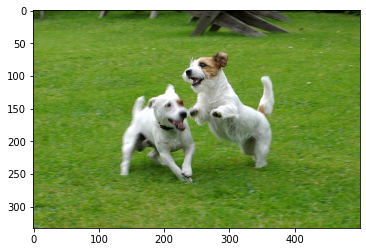

In [ ]:
pic = '717673249_ac998cfbe6.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)
print(test_img)

['/content/gdrive/My Drive/Kaggle/Images/1096395242_fc69f0ae5a.jpg', '/content/gdrive/My Drive/Kaggle/Images/2953015871_cae796b6e7.jpg', '/content/gdrive/My Drive/Kaggle/Images/1386964743_9e80d96b05.jpg', '/content/gdrive/My Drive/Kaggle/Images/3220161734_77f42734b9.jpg', '/content/gdrive/My Drive/Kaggle/Images/464251704_b0f0c4c87a.jpg', '/content/gdrive/My Drive/Kaggle/Images/561940436_64d6fc125d.jpg', '/content/gdrive/My Drive/Kaggle/Images/3670907052_c827593564.jpg', '/content/gdrive/My Drive/Kaggle/Images/3694991841_141804da1f.jpg', '/content/gdrive/My Drive/Kaggle/Images/2496370758_a3fbc49837.jpg', '/content/gdrive/My Drive/Kaggle/Images/2283966256_70317e1759.jpg', '/content/gdrive/My Drive/Kaggle/Images/324208502_674488bcea.jpg', '/content/gdrive/My Drive/Kaggle/Images/113678030_87a6a6e42e.jpg', '/content/gdrive/My Drive/Kaggle/Images/2559503010_84f20b3bc9.jpg', '/content/gdrive/My Drive/Kaggle/Images/2340206885_58754a799a.jpg', '/content/gdrive/My Drive/Kaggle/Images/2698666984_

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)
print(train_descriptions)

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print(all_train_captions)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))
print(vocab)

Vocabulary = 1659
['startseq', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tricolored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'ears', 'rope', 'net', 'red', 'climbs', 'bridge', 'onto', 'ropes', 'playground', 'running', 'grassy', 'garden', 'surro

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print(vocab_size)
print(wordtoix)

1660
{'startseq': 1, 'a': 2, 'child': 3, 'in': 4, 'pink': 5, 'dress': 6, 'is': 7, 'climbing': 8, 'up': 9, 'set': 10, 'of': 11, 'stairs': 12, 'an': 13, 'way': 14, 'endseq': 15, 'girl': 16, 'going': 17, 'into': 18, 'wooden': 19, 'building': 20, 'little': 21, 'the': 22, 'to': 23, 'her': 24, 'black': 25, 'dog': 26, 'and': 27, 'spotted': 28, 'are': 29, 'fighting': 30, 'tricolored': 31, 'playing': 32, 'with': 33, 'each': 34, 'other': 35, 'on': 36, 'road': 37, 'white': 38, 'brown': 39, 'spots': 40, 'staring': 41, 'at': 42, 'street': 43, 'two': 44, 'dogs': 45, 'different': 46, 'looking': 47, 'pavement': 48, 'moving': 49, 'toward': 50, 'covered': 51, 'paint': 52, 'sits': 53, 'front': 54, 'painted': 55, 'rainbow': 56, 'hands': 57, 'bowl': 58, 'sitting': 59, 'large': 60, 'small': 61, 'grass': 62, 'plays': 63, 'it': 64, 'there': 65, 'pigtails': 66, 'painting': 67, 'young': 68, 'outside': 69, 'man': 70, 'lays': 71, 'bench': 72, 'while': 73, 'his': 74, 'by': 75, 'him': 76, 'which': 77, 'also': 78, '

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

 99% 454M/458M [00:05<00:00, 63.2MB/s]
100% 458M/458M [00:05<00:00, 95.5MB/s]


In [ ]:
glove_path = "/content/gdrive/My Drive/Kaggle/glove.6B.200d.txt"
embeddings_index = {} 
f = open(glove_path,  encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.24168999 -0.34534001 -0.22307    ...  0.27801001 -0.10171
  -0.071521  ]
 ...
 [-0.021736    0.15308     0.11436    ...  0.078342   -0.39166999
   0.12937   ]
 [ 0.20298    -0.10048    -0.33627    ...  0.40496999 -0.19888
  -0.10866   ]
 [ 0.41156    -0.25863001  0.016209   ... -0.25419    -0.27496001
   0.67840999]]


In [ ]:
model = InceptionV3(weights='imagenet')
print(model)

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)
print(model_new)

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
    print(preprocess)   

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
print(encoding_train)

{'662606040_8cc8cd9f1b.jpg': array([0.18314071, 0.27974784, 0.2862537 , ..., 1.340678  , 0.19824517,
       0.01116209], dtype=float32), '3613323772_d15cef66d1.jpg': array([0.03916238, 0.20340443, 0.10231867, ..., 0.45535266, 0.13296358,
       0.3142319 ], dtype=float32), '3324746155_71e14f60ce.jpg': array([0.1863938 , 0.6326765 , 0.21866053, ..., 0.34543154, 0.04582839,
       0.82252675], dtype=float32), '2222559267_6fd31e3941.jpg': array([0.3127021 , 0.0305148 , 0.6225563 , ..., 0.6343666 , 0.45760992,
       0.14753014], dtype=float32), '215876547_fa584c5ec3.jpg': array([0.251897  , 0.43604088, 0.2840944 , ..., 0.24503762, 0.49045193,
       0.17474486], dtype=float32), '2827964381_408a310809.jpg': array([0.392236  , 0.35680938, 0.3289121 , ..., 0.10171363, 0.58485293,
       0.38934025], dtype=float32), '1397923690_d3bf1f799e.jpg': array([0.20327505, 0.12905274, 0.2533569 , ..., 0.73612875, 0.35641727,
       0.06401716], dtype=float32), '3173215794_6bdd1f72d4.jpg': array([1.2203

In [ ]:
print(encoding_test)

{'1096395242_fc69f0ae5a.jpg': array([0.65066314, 0.9936036 , 0.5315552 , ..., 1.0775847 , 0.8147503 ,
       0.18483719], dtype=float32), '2953015871_cae796b6e7.jpg': array([0.8383631 , 0.6275719 , 0.07204144, ..., 0.6281146 , 0.7137834 ,
       0.40873194], dtype=float32), '1386964743_9e80d96b05.jpg': array([0.36373407, 0.9754601 , 0.5230444 , ..., 0.17792505, 0.81822336,
       0.5366496 ], dtype=float32), '3220161734_77f42734b9.jpg': array([0.3784203 , 0.14224342, 0.2839262 , ..., 0.38184   , 0.20014794,
       0.00043983], dtype=float32), '464251704_b0f0c4c87a.jpg': array([0.41965166, 0.25137305, 0.6422969 , ..., 0.28995866, 0.5172684 ,
       0.47752747], dtype=float32), '561940436_64d6fc125d.jpg': array([0.16603222, 0.23155233, 0.48766816, ..., 0.45544404, 0.04839388,
       0.22719173], dtype=float32), '3670907052_c827593564.jpg': array([0.07458681, 0.569255  , 0.15832414, ..., 0.2789086 , 0.26874304,
       0.2781857 ], dtype=float32), '3694991841_141804da1f.jpg': array([0.2675

In [ ]:
print(train_features)

{'662606040_8cc8cd9f1b.jpg': array([0.18314071, 0.27974784, 0.2862537 , ..., 1.340678  , 0.19824517,
       0.01116209], dtype=float32), '3613323772_d15cef66d1.jpg': array([0.03916238, 0.20340443, 0.10231867, ..., 0.45535266, 0.13296358,
       0.3142319 ], dtype=float32), '3324746155_71e14f60ce.jpg': array([0.1863938 , 0.6326765 , 0.21866053, ..., 0.34543154, 0.04582839,
       0.82252675], dtype=float32), '2222559267_6fd31e3941.jpg': array([0.3127021 , 0.0305148 , 0.6225563 , ..., 0.6343666 , 0.45760992,
       0.14753014], dtype=float32), '215876547_fa584c5ec3.jpg': array([0.251897  , 0.43604088, 0.2840944 , ..., 0.24503762, 0.49045193,
       0.17474486], dtype=float32), '2827964381_408a310809.jpg': array([0.392236  , 0.35680938, 0.3289121 , ..., 0.10171363, 0.58485293,
       0.38934025], dtype=float32), '1397923690_d3bf1f799e.jpg': array([0.20327505, 0.12905274, 0.2533569 , ..., 0.73612875, 0.35641727,
       0.06401716], dtype=float32), '3173215794_6bdd1f72d4.jpg': array([1.2203

In [ ]:
# Feature Extractor Model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence Generation Model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

#Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#Merge the 2 models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 221s 104ms/step - loss: 4.1667
Epoch 2/30
2000/2000 [==============================] - 207s 104ms/step - loss: 3.0978
Epoch 3/30
2000/2000 [==============================] - 204s 102ms/step - loss: 2.8645
Epoch 4/30
2000/2000 [==============================] - 203s 102ms/step - loss: 2.7370
Epoch 5/30
2000/2000 [==============================] - 204s 102ms/step - loss: 2.6479
Epoch 6/30
2000/2000 [==============================] - 204s 102ms/step - loss: 2.5786
Epoch 7/30
2000/2000 [==============================] - 202s 101ms/step - loss: 2.5265
Epoch 8/30
2000/2000 [==============================] - 201s 101ms/step - loss: 2.4831
Epoch 9/30
2000/2000 [==============================] - 200s 100ms/step - loss: 2.4476
Epoch 10/30
2000/2000 [==============================] - 197s 99ms/step - loss: 2.4136
Epoch 11/30
2000/2000 [==============================] - 196s 98ms/step - loss: 2.3891
Epoch 12/30
2000/2000 [====================

In [ ]:
target_dir = '/content/gdrive/My Drive/Kaggle/models'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('/content/gdrive/My Drive/Kaggle/models/model.h5')
model.save_weights('/content/gdrive/My Drive/Kaggle/models/weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from google.colab import files
files.download('/content/gdrive/My Drive/Kaggle/models/model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

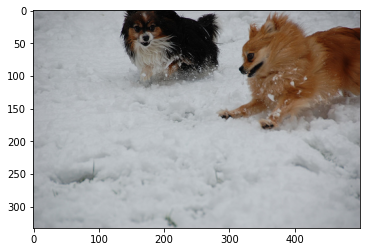

Greedy Search: a dog is running through the snow
Beam Search, K = 3: a white dog is running through the snow
Beam Search, K = 5: a brown and white dog is running through the snow
Beam Search, K = 7: a brown and white dog is running through the snow
Beam Search, K = 10: a brown and white dog running through the snow


In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

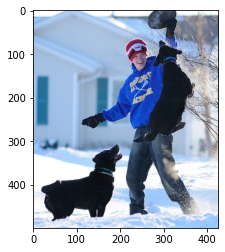

Greedy: a dog is running through the snow
Beam Search, K = 3: a black dog runs through the snow
Beam Search, K = 5: a black dog runs through the snow
Beam Search, K = 7: a brown and white dog running through the snow


In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))